This notebook focuses on using GPR (acq. func is EI) to perform BO to determine maximum h.
1. X -> Viscosity, density, thermal conductivity, heat capacity (thermophysical properties); y -> h
2. Random sampling was done on indices of dataset and then did initial_X, initial_y = X[indices], y[indices]
3. Using initial_X, initial_y, active learning loop was constructed (this is the base code for GPR BO)
4. Comparison with random model was also done towards the end

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import BayesianOptimizer
from modAL.acquisition import optimizer_EI, max_EI #using EI as acq. function for now; can adjust

import warnings
%matplotlib inline

In [2]:
df = pd.read_excel("dataset/Dataset.xlsx")

In [3]:
df_interest = df[['Viscosity (cP)', 'Density (kg/m^3)', 'Thermal Conductivity (W/m.k)', 'Heat Capacity (J/(kg.K))', 'Heat Transfer Coefficient']]

In [4]:
X = df_interest[['Viscosity (cP)', 'Density (kg/m^3)', 'Thermal Conductivity (W/m.k)', 'Heat Capacity (J/(kg.K))']].to_numpy() #full X
y = df_interest['Heat Transfer Coefficient'].to_numpy() #full y

### For one run through GPR for n_iter = 50

In [5]:
from models.baseline_models import get_h_best, random_sampling, get_rank_best

In [6]:
min_vals = np.min(X, axis = 0)
max_vals = np.max(X, axis = 0)
X_norm = (X - min_vals)/(max_vals - min_vals)

In [7]:
indices = np.load('dataset/initial_indices.npy')
indices

array([ 465, 1146,  545,  251,  523, 1023,  425,  683, 1103,  719])

In [8]:
initial_X, initial_y = X_norm[indices], y[indices]

X_pool, y_pool = X_norm.copy(), y.copy()

h_best, h_pred = get_h_best(initial_X, initial_y, X_pool, y_pool)

Iteration num. 1


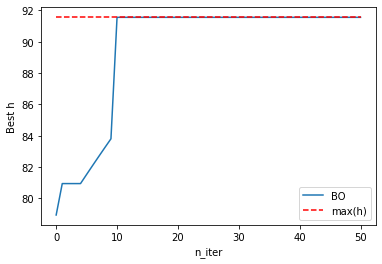

In [9]:
n_iterations = 50

plt.plot(h_best)
plt.plot(np.linspace(0, n_iterations, n_iterations), [np.max(y)]*n_iterations, 'r--')

plt.xlabel('n_iter')
plt.ylabel('Best h')
plt.legend(['BO', 'max(h)'])

#### Running GPR 20 separate times for n_iter = 50
Stochasticity introduced in initial_X and initial_y indices being randomized each time

In [10]:
#create h -> rank mapping

sorted_unique_h = sorted(set(y), reverse=True)
value_to_rank = {value: rank+1 for rank, value in enumerate(sorted_unique_h)}
h_to_rank = {element: value_to_rank[element] for element in y} #{h : rank}

In [11]:
#get top N%
N_perc = 20
h_threshold = np.percentile(y, q = 100 - N_perc) #get h threshold value that would take it to top N%
print(f'h threshold is {h_threshold} in top {N_perc} %')

h threshold is 70.96447501689761 in top 20 %


In [12]:
n_run = 20
h_best_matrix = []
h_pred_matrix = []
rank_best_matrix = []

for _ in range(n_run):
    indices = np.random.choice(len(X_norm), size = 10, replace = False)
    initial_X, initial_y = X_norm[indices], y[indices]

    h_best, h_pred = get_h_best(initial_X, initial_y, X_norm, y, n_iterations=50)
    rank_best = get_rank_best(initial_X, initial_y, X_norm, y, h_to_rank, n_iterations = 50)
    h_best_matrix.append(h_best)
    h_pred_matrix.append(h_pred)
    rank_best_matrix.append(np.log10(rank_best))

h_best_matrix = np.array(h_best_matrix)
h_pred_matrix = np.array(h_pred_matrix)
rank_best_matrix = np.array(rank_best_matrix)

Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1


In [13]:
#this is for BO (non-rank)
std_dev_vector = np.std(h_best_matrix, axis = 0)
mean_vector = np.mean(h_best_matrix, axis = 0)

#this is for BO (rank)
std_dev_rank = np.std(rank_best_matrix, axis = 0)
mean_rank = np.mean(rank_best_matrix, axis = 0)

In [14]:
#We want to compare to random model
h_best_rand_matrix = []
rank_rand_matrix = []

for _ in range(n_run):
    
    h_best_rand = random_sampling(X_norm, y, n_iterations = 50)
    
    temporary_rank_array = []
    for i in h_best_rand:
        temporary_rank_array.append(np.log(h_to_rank[i]))

    h_best_rand_matrix.append(h_best_rand)
    rank_rand_matrix.append(temporary_rank_array)

h_best_rand_matrix = np.array(h_best_rand_matrix)
rank_rand_matrix = np.array(rank_rand_matrix)

Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1
Iteration num. 1


In [15]:
#this is for random sampling (best h)
std_dev_rand = np.std(h_best_rand_matrix, axis = 0)
mean_rand = np.mean(h_best_rand_matrix, axis = 0)

#this is for random sampling (best rank)
std_rank_rand = np.std(rank_rand_matrix, axis = 0)
mean_rank_rand = np.mean(rank_rand_matrix, axis = 0)

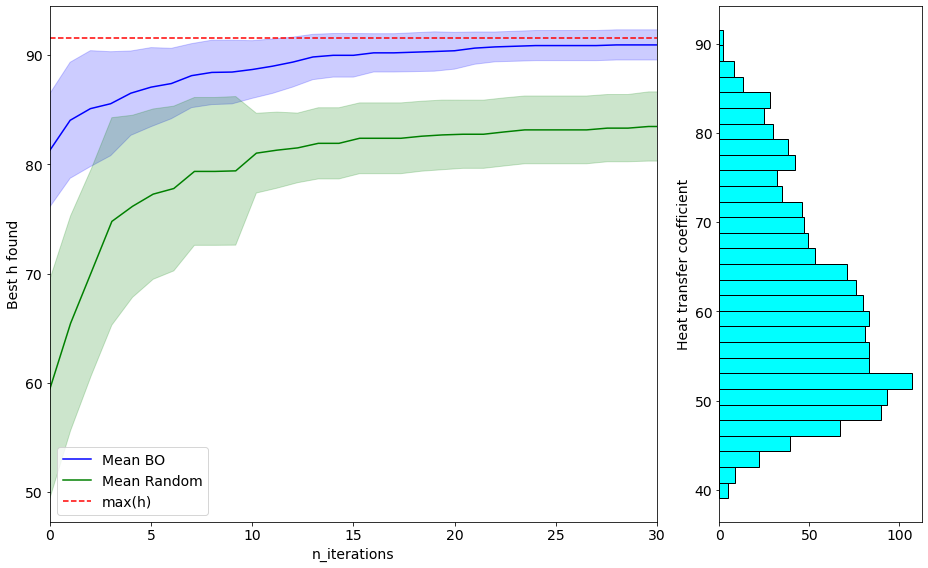

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize = (13, 8))

ax1.plot(np.linspace(0, 50, 51), mean_vector, label='Mean BO', color='blue')
ax1.fill_between(np.linspace(0, 50, 51), mean_vector - std_dev_vector, mean_vector + std_dev_vector, color='blue', alpha=0.2)

ax1.plot(np.linspace(0, 50, 50), mean_rand, label = 'Mean Random', color = 'green')
ax1.fill_between(np.linspace(0, 50, 50), mean_rand - std_dev_rand, mean_rand + std_dev_rand, color='green', alpha=0.2)
ax1.set_xlabel('n_iterations', fontsize = 14)
ax1.set_ylabel('Best h found', fontsize = 14)
ax1.set_xlim([0, 30])

ax1.plot(np.linspace(0, 50, 50), [np.max(y)]*50, 'r--', label = 'max(h)')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(fontsize = 14)

ax2.hist(y, bins = 30, edgecolor = 'black', color = 'aqua', orientation='horizontal')
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_ylabel('Heat transfer coefficient', fontsize = 14)

plt.tight_layout()

plt.savefig('figures/random_vs_BO.svg')
plt.show()

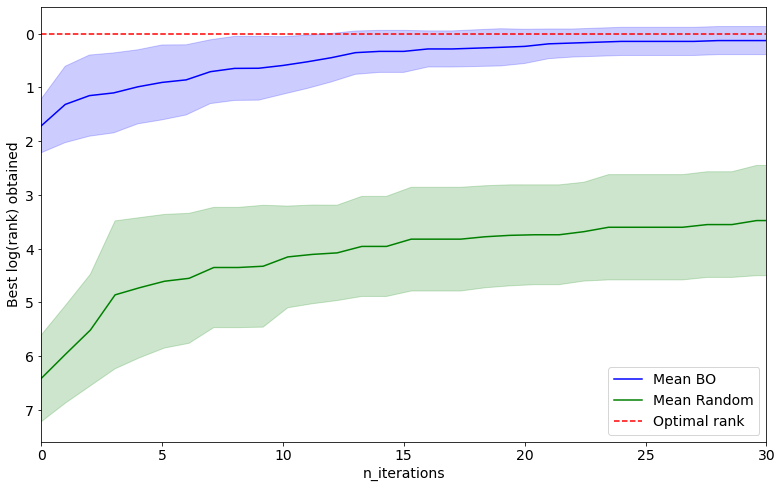

In [34]:
plt.figure(figsize = (13, 8))

plt.plot(np.linspace(0, 50, 51), mean_rank, label = 'Mean BO', color = 'blue')
plt.fill_between(np.linspace(0, 50, 51), mean_rank - std_dev_rank, mean_rank + std_dev_rank, color='blue', alpha=0.2)

plt.plot(np.linspace(0, 50, 50), mean_rank_rand, label = 'Mean Random', color = 'green')
plt.fill_between(np.linspace(0, 50, 50), mean_rank_rand - std_rank_rand, mean_rank_rand + std_rank_rand, color='green', alpha=0.2)

plt.plot(np.linspace(0, 50, 50), [np.log10(1)]*50, 'r--', label = 'Optimal rank')

plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('n_iterations', fontsize = 14)
plt.ylabel('Best log(rank) obtained', fontsize = 14)
plt.xlim([0, 30])

plt.legend(fontsize = 14)
plt.savefig('figures/rank_BO_random.svg')
plt.show()

In [43]:
threshold_val = [x for x in y if x >= h_threshold]

In [44]:
fractions = []

for i in h_pred_matrix:
    fraction_temp, n_m, n_T = [], 0, len(threshold_val) #temporary array, not in final results
    for j in i:
        if j in threshold_val:
            n_m = n_m + 1
            fraction_temp.append(n_m/n_T)
        else:
            n_m = n_m
            fraction_temp.append(n_m/n_T)
    
    fractions.append(fraction_temp)

fractions = np.array(fractions)

In [45]:
fractions_rand = []

for i in h_best_rand_matrix:
    fraction_temp, n_m, n_T = [], 0, len(threshold_val) #temporary array, not in final results
    for j in i:
        if j in threshold_val:
            n_m = n_m + 1
            fraction_temp.append(n_m/n_T)
        else:
            n_m = n_m
            fraction_temp.append(n_m/n_T)
    
    fractions_rand.append(fraction_temp)

fractions_rand = np.array(fractions_rand)

In [46]:
fraction_mean = np.mean(fractions, axis = 0)
fraction_std = np.std(fractions, axis = 0)

frac_rand_mean = np.mean(fractions_rand, axis = 0)
frac_rand_std = np.std(fractions_rand, axis = 0)

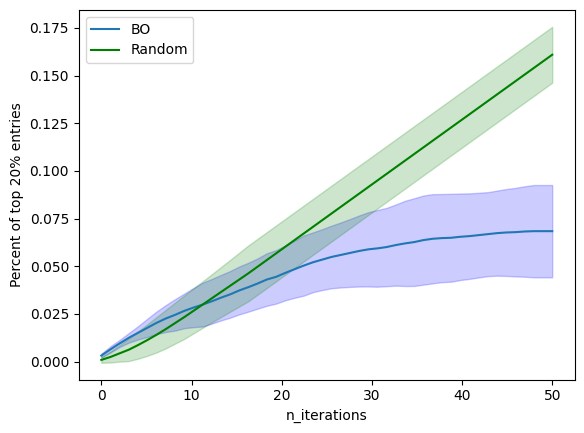

In [47]:
plt.plot(np.linspace(0, 50, 50), fraction_mean, label = 'BO')
plt.fill_between(np.linspace(0, 50, 50), fraction_mean - fraction_std, fraction_mean + fraction_std, color='blue', alpha=0.2)

plt.plot(np.linspace(0, 50, 50), frac_rand_mean, color = 'green', label = 'Random')
plt.fill_between(np.linspace(0, 50, 50), frac_rand_mean - frac_rand_std, frac_rand_mean + frac_rand_std, color='green', alpha=0.2)

plt.xlabel('n_iterations')
plt.ylabel(f'Percent of top {N_perc}% ' + 'entries')

plt.legend()
plt.show()